In [4]:
import numpy as np
import time
import pandas as pd 
import matplotlib.pyplot as plt
import math 
import random
import scipy.io as spio
import collections
from sklearn.model_selection import train_test_split

columns = ['coluna 1', 'coluna 2']
train = pd.read_csv("cluster.dat", decimal=".", sep=' ', names=columns)
eps = 0.005
minpts = 10

In [5]:
def normalize(data):
  normData = data.copy()
  for i in range(data.shape[1]):
    normData.iloc[:,i] /= np.linalg.norm(data.iloc[:,i])
  return normData

In [6]:
def split_dataset(data, p=0.9): 
  embaralhado = data.iloc[np.random.permutation(len(data))]
  d1 = embaralhado.iloc[0:int(embaralhado.shape[0]*p),:]
  d2 = embaralhado.iloc[int(embaralhado.shape[0]*p):,:]
  return d1,d2


In [7]:
def module(i, j):
    return np.linalg.norm(i - j)
def distance_two_points (i,j):
    return math.sqrt(abs(sum(i**2-j**2)))
def distance(V):
    return math.sqrt(sum(v**2 for v in V))

In [8]:
def ExpandClusters(data, points_labels, id_seed, neighbor_points, C, epsilon, min_pts, core_points):
    # coloca o id do cluster no ponto atual
    points_labels[id_seed] = C
   
    i = 0
    while i < len(neighbor_points):        
        next_position = neighbor_points[i]
        if points_labels[next_position] == 0:
           points_labels[next_position] = C
        
        # se o ponto vizinho ainda nao tinha cluster agora ele tem
        elif points_labels[next_position] == -1:
            points_labels[next_position] = C
            
            pn_neighbor = [i for i in range(len(data)) if np.linalg.norm(data.iloc[i,:]-data.iloc[next_position,:]) <= epsilon]
            #se o ponto tem filhos, adiciona eles na fila 
            if len(pn_neighbor) > min_pts:
                neighbor_points = neighbor_points + pn_neighbor
                core_points.append(next_position) # = np.append(core_points, next_position,dtype = int)
        i += 1
    return core_points

In [9]:
def effDBSCAN(data, epsilon, minP):
  C = 0
  point_label = np.full(len(data), -1, dtype=int) 
  core_points = []
  for p in range(len(data)):
    if point_label[p] != -1: continue
    current_point = data.iloc[p]
    # armazena os pontos vizinhos ao ponto p.
    neighbor_points = [i for i in range(len(data)) if np.linalg.norm(data.iloc[i,:]-current_point) <= epsilon]
  
    # o ponto nao tem vizinhos o suficiente
    if len(neighbor_points) <= minP:
      point_label[p] = 0
    # tem vizinhos o suficiente para criar um novo clusters
    else:
      C += 1
      core_points.append(p) # = np.append(core_points, p)
      core_points = ExpandClusters(data, point_label, p, neighbor_points, C, epsilon, minP, core_points)

  return point_label, core_points, C


In [10]:
#Function to plot final result
def plotRes(train, point_labels, main_title):
  dicColors = {0:'black', 1:'orange', 2:'purple', 3:'red', 4:'blue', 5:'green', 
              6:'yellow', 7:'violet', 8:'brown'}    
  label_color = [dicColors[c%9] for c in point_labels] 
  x_label = 'x axis'
  y_label = 'y axis'
  title = main_title 
  plt.figure(figsize=(15,15))
  plt.scatter(train.iloc[:,0],train.iloc[:,1],c=label_color,alpha=0.3)
  plt.suptitle(title, fontsize=20)
  plt.suptitle(title, fontsize=20)  
  plt.suptitle(title, fontsize=20)  
  plt.savefig(title + '.png')
  plt.show()

In [11]:
def callPlot(train_data,pointlabel, main_title):
  # cl = len(pointlabel)
  plotRes(train_data, pointlabel, main_title) 
  plt.show()
  # print('number of cluster found: ' + str(cl-1))
  counter=collections.Counter(pointlabel)
  print(counter)
  outliers  = np.count_nonzero(pointlabel == 0)
  print('number of outliers found: '+str(outliers) +'\n')

In [12]:
# checar depois: https://gist.github.com/AlexandreAbraham/5544803
def find_clusters_and_centroids_all_pts(norm_dataset, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in range(len(norm_dataset)):    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

def find_clusters_and_centroids(norm_dataset, core_points, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in core_points:    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

In [25]:
def dist_intra_clusters_index (norm_data, clusters, centroids, i):
  B = [[abs(norm_data.iloc[round(clusters[i][j])] - centroids[i][0]) 
          for j in range(len(clusters[i]))]
           ] # for i in range(len(clusters))]
  return B

# search for math.dist(p, q) later :)
def dist_intra_clusters(norm_data, clusters, centroids):
    centroids = np.asarray(centroids)
    B = 0
    dist = 0
    elbow = 0
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not math.isnan(clusters[i][j]) and not math.isnan(centroids[i][0][0]): 
                # soma += np.abs(norm_data.iloc[round(clusters[i][j])] - centroids[i][0])    
                dist += math.dist(norm_data.iloc[round(clusters[i][j])], centroids[i][0])
                elbow += dist**2
    B = dist
    return B, elbow
  

In [14]:
def dist_centroids(centroids, c1, c2):
    return abs(centroids[c1][0] - centroids[c2][0])

def dist_inter_clusters(centroids):
    centroids =np.asarray(centroids)
    A = 0
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            if not math.isnan(centroids[i][0][0]) and not math.isnan(centroids[j][0][0]): 
                # A += np.abs(centroids[i][0] - centroids[j][0])
                A += math.dist(centroids[i][0], centroids[j][0])
    return A 

In [15]:
def calc_silhouette (A, B):
    a = A
    b = B
    if (type(A) is type([])):
        a = distance(A) # distance (dist_inter_clusters(centroids))
    if (type(B) is type([])):
        b = distance(B) # ditance (dist_intra_clusters(norm_dataset, clusters, centroids))
    sil = (b - a)/(max(a, b)+0.000001)
    print("A: {}\nB: {}\na___b___sil: {}____{}____{}\n".format(A, B, a, b, sil))
    return sil
    

In [30]:
def inertia_val(v):
    return v**2
def inertia(V):
    return sum(v**2 for v in V)
def calc_elbow(B):
    if(type(B) is type(0) or type(0.)):
        return B
    else:
        return inertia(B)

In [17]:
def predict(pred_dataset, norm_orig_dataset, clusters, orig_point_labels, eps):
    norm_pred_dataset = pred_dataset # normalize(pred_dataset).to_numpy()
    pred_point_labels = np.zeros(len(norm_pred_dataset),dtype=int)
    for i in range(len(norm_pred_dataset)):
        for j in range(len(clusters)):
            for cp in clusters[j]:
                cp = round(cp)
                dist = np.linalg.norm(norm_pred_dataset.iloc[i,:] - norm_orig_dataset.iloc[cp,:]) 
                
                if (dist  <= eps):
                    pred_point_labels[i] = orig_point_labels[cp] 
                    break  
    return pred_point_labels

In [18]:
def validate(dataset, 
             epsilon=[0.001, 0.003, 0.006, 0.009, 0.02, 0.04, 0.06, 0.08],
             minpts=10):
  somaDasSilhuetas = []
  somaDosQuadrados = []
  for eps in epsilon:
    print("epsilon: {}".format(eps))
    norm_dataset = dataset # normalize(dataset).to_numpy()
    point_labels, core_points, n_clusters = effDBSCAN(norm_dataset,eps,minpts)
    clusters, centroids = find_clusters_and_centroids(
                          norm_dataset, core_points, point_labels, n_clusters
    )
    inter = dist_inter_clusters(centroids)
    intra, elbow = dist_intra_clusters(norm_dataset, clusters, centroids)
    somaDosQuadrados.append(calc_elbow(elbow))
    somaDasSilhuetas.append(calc_silhouette(inter, intra))
    callPlot(dataset, point_labels, "DBSCAN clusters for eps: "+ str(eps))
  
  print("Cotovelo:")
  print(somaDosQuadrados)
  plt.plot(epsilon, somaDosQuadrados, 'x-')
  plt.xlabel('epsilon')
  plt.ylabel('Soma dos quadrados')
  
  print("Silhuetas:")
  print(somaDasSilhuetas)
  plt.plot(epsilon, somaDasSilhuetas, 'go')
  plt.xlabel('epsilon')
  plt.ylabel('Coeficiente de Silhueta')

In [19]:
# Split and initialize training & validation & test data separately
norm_train = normalize(train) # .to_numpy()
training, test = split_dataset(norm_train)
training, validation = split_dataset(training)
norm_training =  normalize(training) # .to_numpy()

In [20]:
point_labels, core_points, n_clusters = effDBSCAN(norm_train,eps,minpts)

In [21]:
point_labels_train, core_points_train, n_clusters_train = effDBSCAN(norm_training, eps, minpts)

In [22]:
clusters_train, centroids_train = find_clusters_and_centroids(
    norm_training, core_points_train, point_labels_train, n_clusters_train
)

In [23]:
point_labels_valid = predict(validation, norm_training, clusters_train, point_labels_train, eps)

     coluna 1  coluna 2
2    0.029349  0.068318
469  0.066720  0.043256
82   0.013913  0.056028
250  0.025693  0.008916
233  0.026505  0.016748
316  0.031888  0.017230
430  0.047324  0.023736
417  0.044582  0.018194
23   0.020818  0.065667
359  0.040215  0.018073
381  0.038082  0.023014
445  0.066923  0.037713
177  0.024068  0.023616
470  0.067939  0.042051
540  0.068446  0.059883
441  0.049355  0.013615
203  0.026810  0.022532
180  0.027622  0.026749
449  0.066517  0.041689
48   0.019092  0.061570
90   0.008429  0.049039
514  0.073829  0.049642
287  0.035747  0.010362
335  0.039098  0.014338
315  0.033715  0.016507
12   0.024779  0.069041
55   0.019193  0.056269
298  0.038285  0.007711
5    0.027115  0.068559
44   0.015334  0.063378
278  0.031888  0.015302
364  0.046816  0.008073
201  0.025084  0.020363
571  0.072509  0.063016
412  0.042144  0.021086
116  0.018076  0.042533
171  0.021123  0.025423
193  0.025997  0.024339
261  0.027622  0.006145
18   0.022646  0.069161
227  0.028943  0

epsilon: 0.001
A: 0
B: 0
a___b___sil: 0____0____0.0



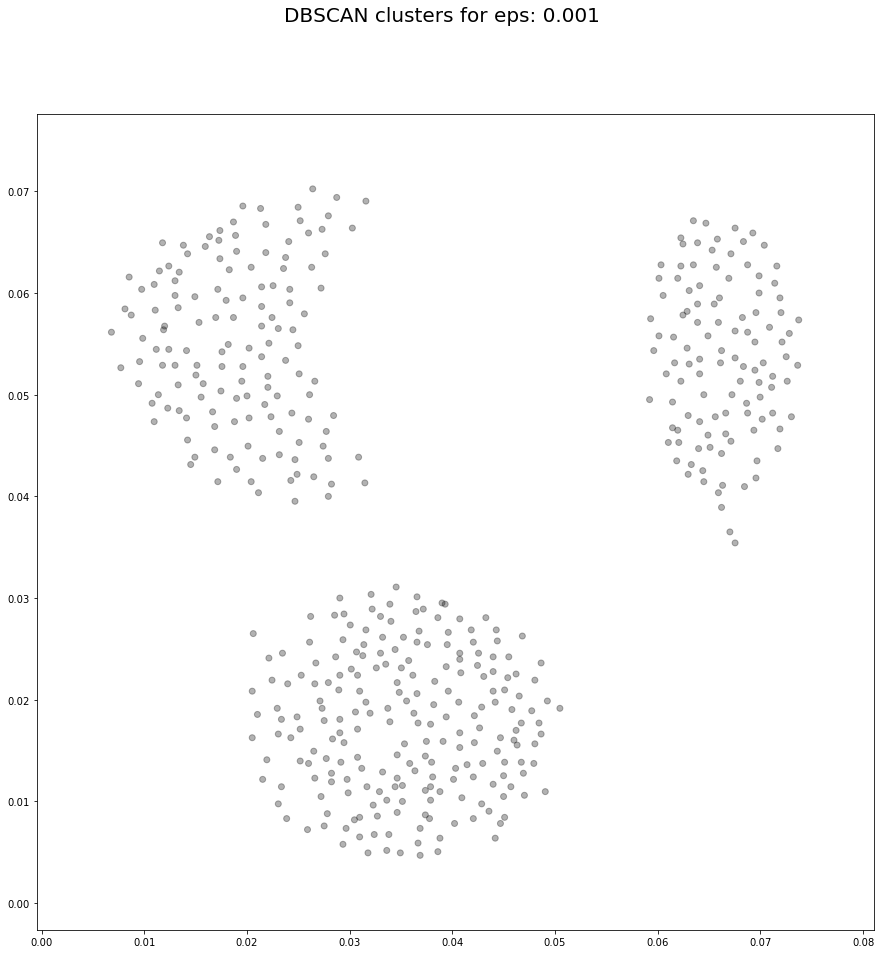

number of cluster found: 462
Counter({0: 463})
number of outliers found: 463

epsilon: 0.003
A: 0.1367204560929508
B: 3.111747510882241
a___b___sil: 0.1367204560929508____3.111747510882241____0.9560628194679563



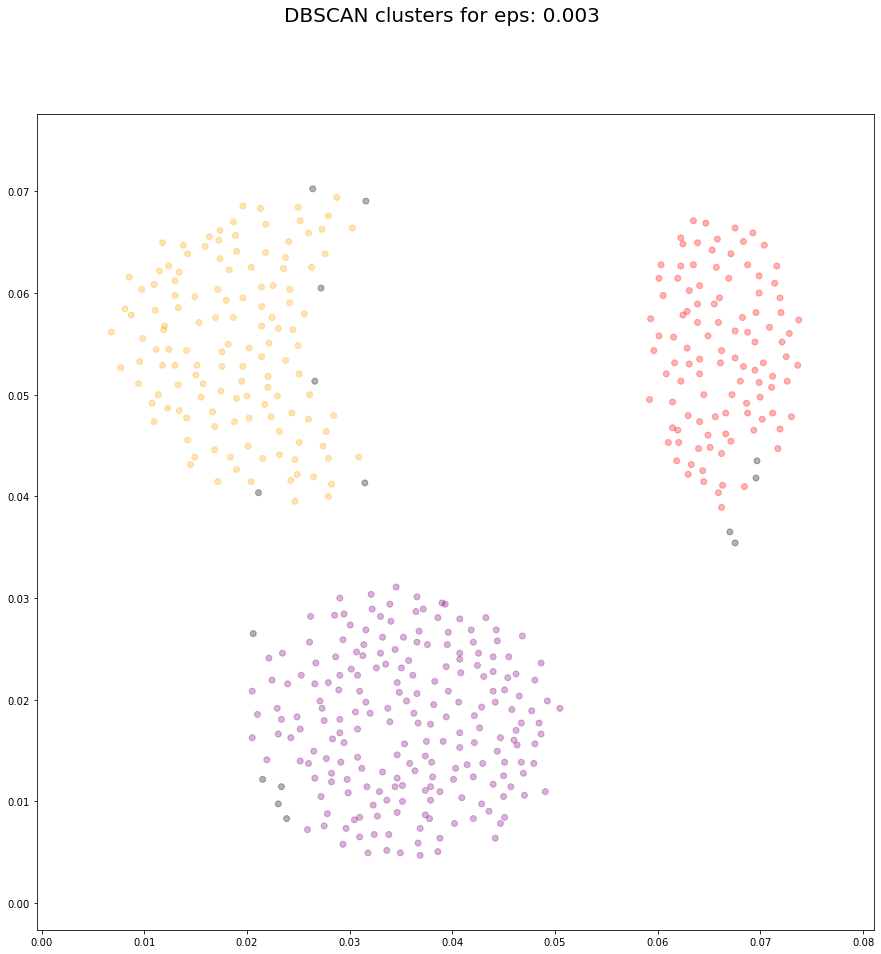

number of cluster found: 462
Counter({2: 210, 1: 132, 3: 106, 0: 15})
number of outliers found: 15

epsilon: 0.006
A: 0.13469075610765888
B: 4.16360818998998
a___b___sil: 0.13469075610765888____4.16360818998998____0.9676502404616935



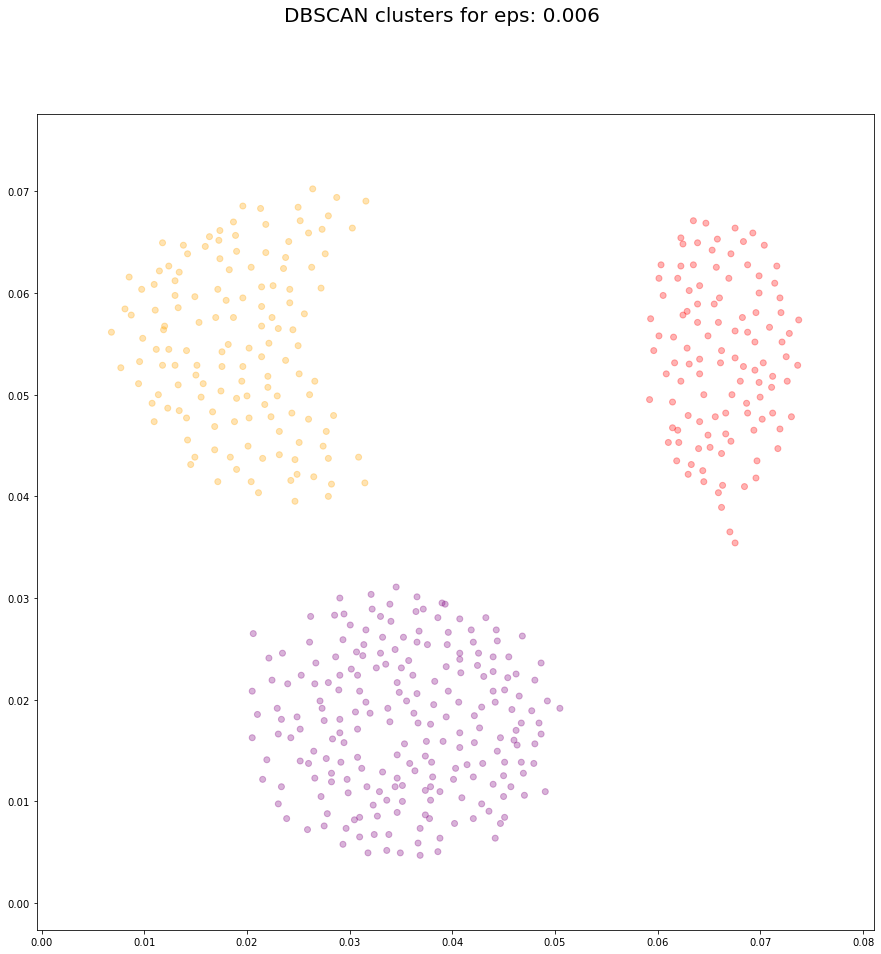

number of cluster found: 462
Counter({2: 215, 1: 138, 3: 110})
number of outliers found: 0

epsilon: 0.009
A: 0.13469075610765888
B: 4.163608189989981
a___b___sil: 0.13469075610765888____4.163608189989981____0.9676502404616935



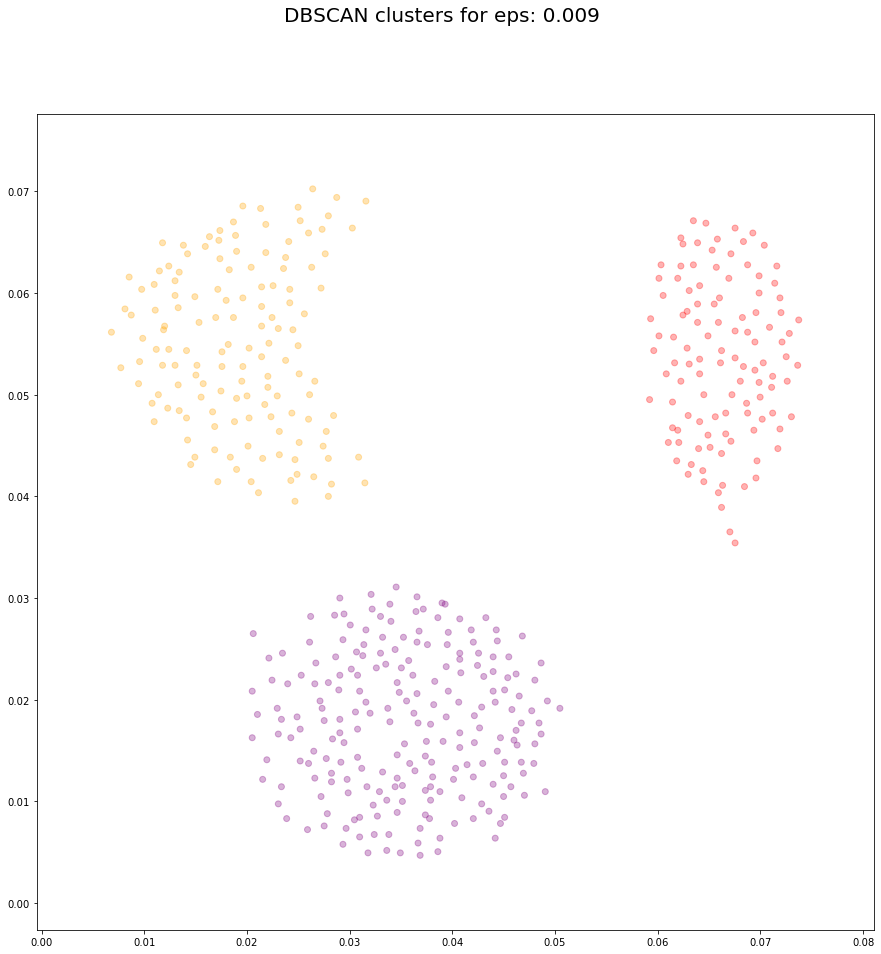

number of cluster found: 462
Counter({2: 215, 1: 138, 3: 110})
number of outliers found: 0

epsilon: 0.02
A: 0.04272510439589115
B: 8.137872257717882
a___b___sil: 0.04272510439589115____8.137872257717882____0.9947497210827939



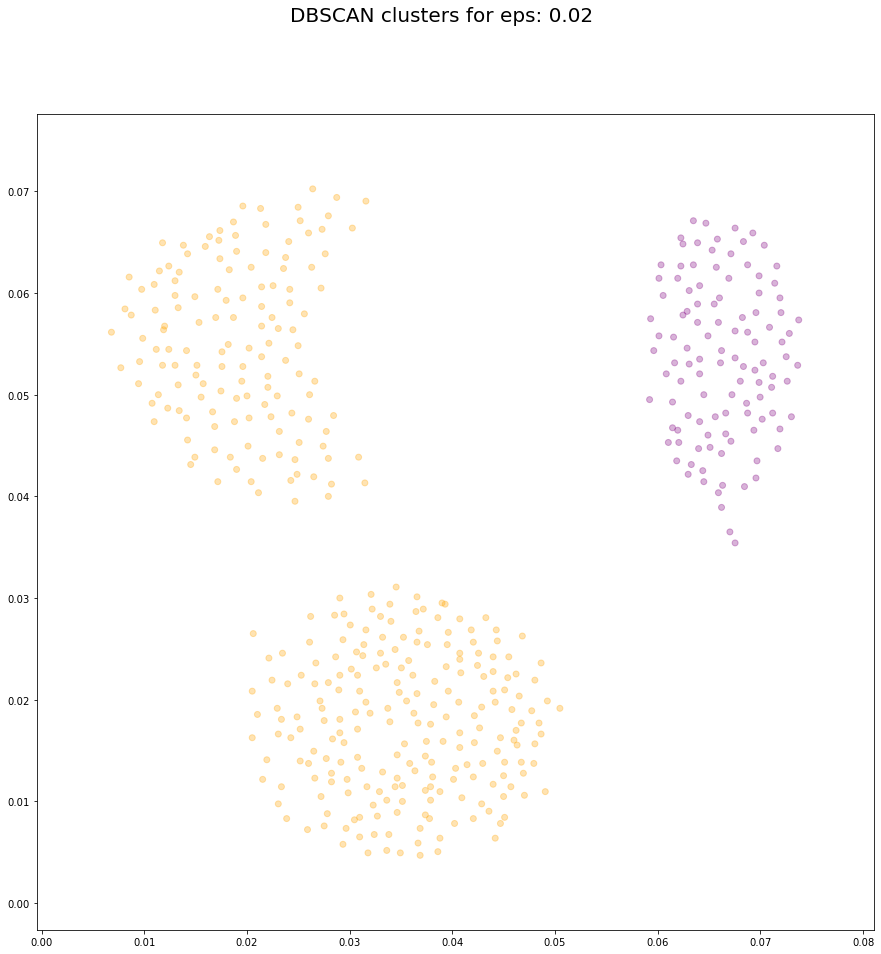

number of cluster found: 462
Counter({1: 353, 2: 110})
number of outliers found: 0

epsilon: 0.04
A: 0
B: 11.875385596823042
a___b___sil: 0____11.875385596823042____0.9999999157922151



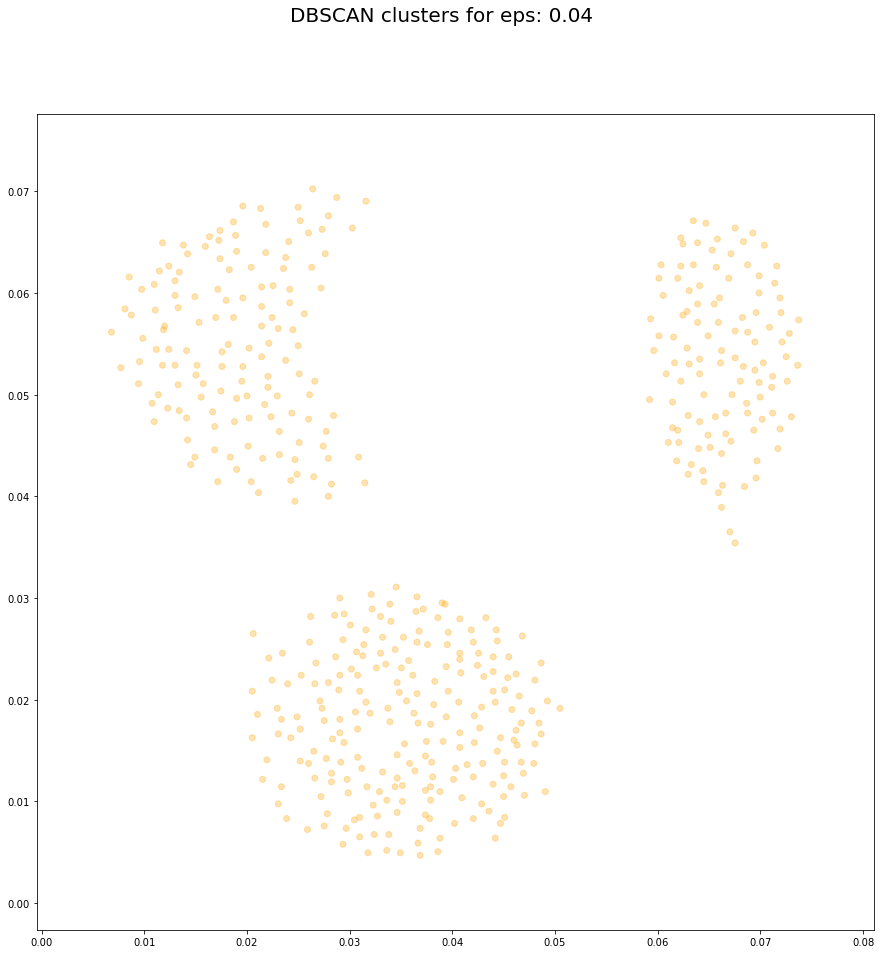

number of cluster found: 462
Counter({1: 463})
number of outliers found: 0

epsilon: 0.06
A: 0
B: 11.87538559682303
a___b___sil: 0____11.87538559682303____0.9999999157922151



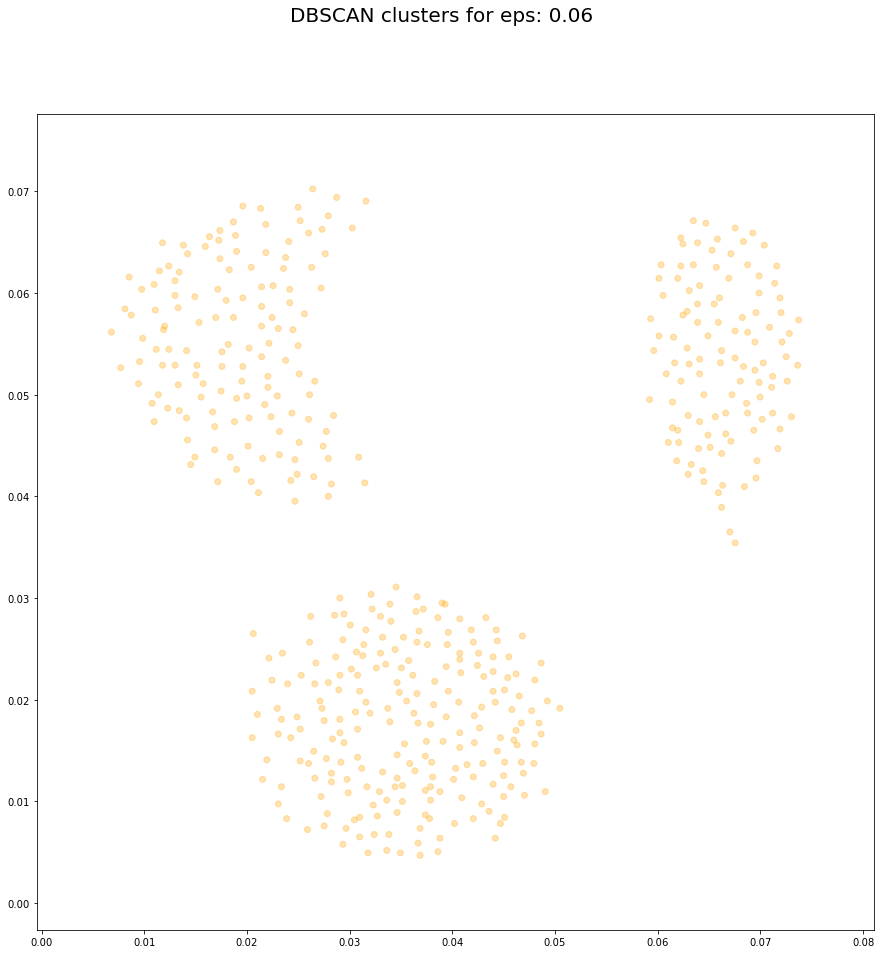

number of cluster found: 462
Counter({1: 463})
number of outliers found: 0

epsilon: 0.08
A: 0
B: 11.87538559682303
a___b___sil: 0____11.87538559682303____0.9999999157922151



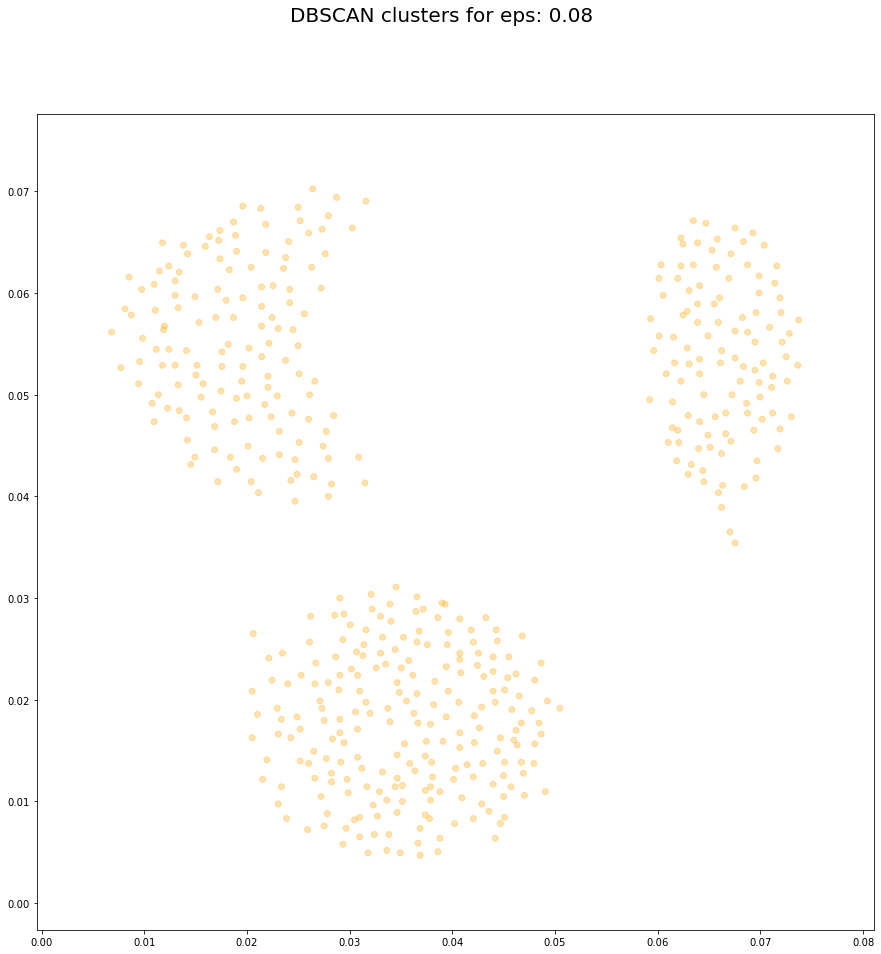

number of cluster found: 462
Counter({1: 463})
number of outliers found: 0

Cotovelo:
[0, 1451374.597237307, 7116778.778606215, 7239809.539283774, 150574313.9073454, 366041799.611887, 465589674.6951841, 465589674.6951841]
Silhuetas:
[0.0, 0.9560628194679563, 0.9676502404616935, 0.9676502404616935, 0.9947497210827939, 0.9999999157922151, 0.9999999157922151, 0.9999999157922151]


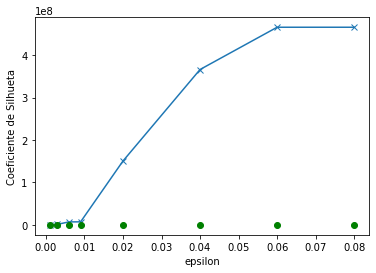

In [29]:
validate(training)

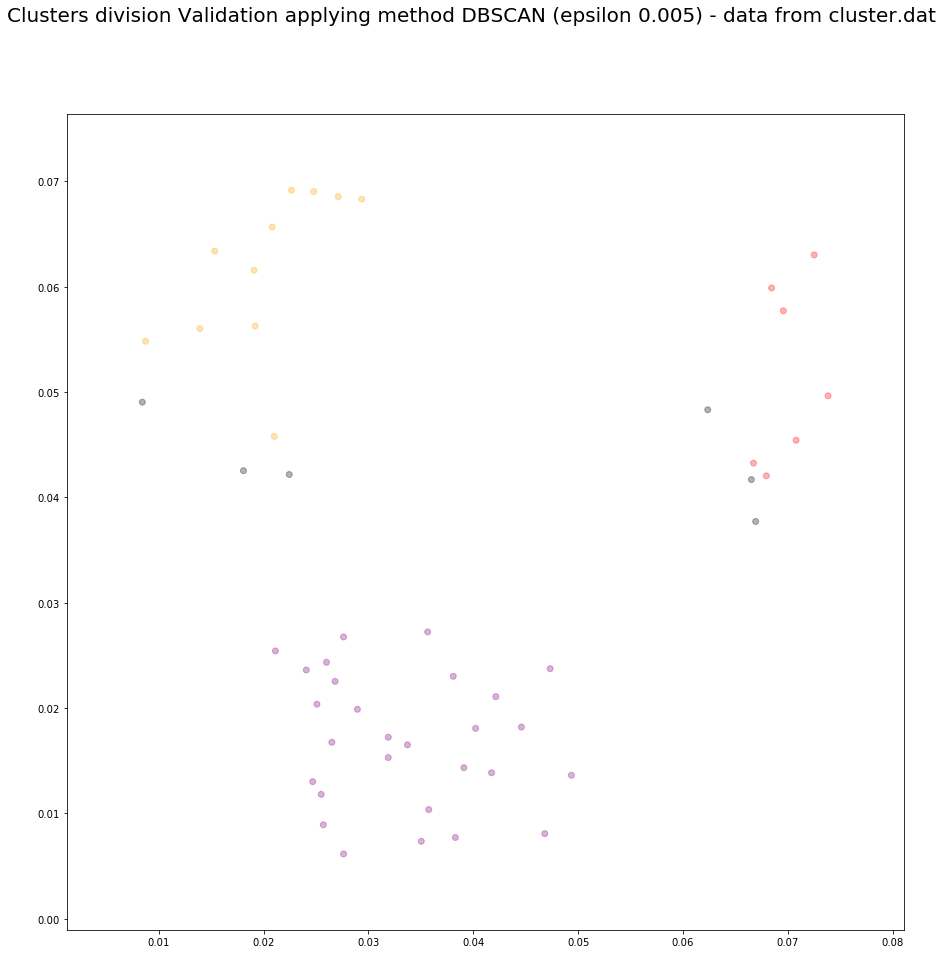

number of cluster found: 51
Counter({2: 28, 1: 11, 3: 7, 0: 6})
number of outliers found: 6



In [27]:
callPlot(validation,point_labels_valid,
     'Clusters division Validation applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

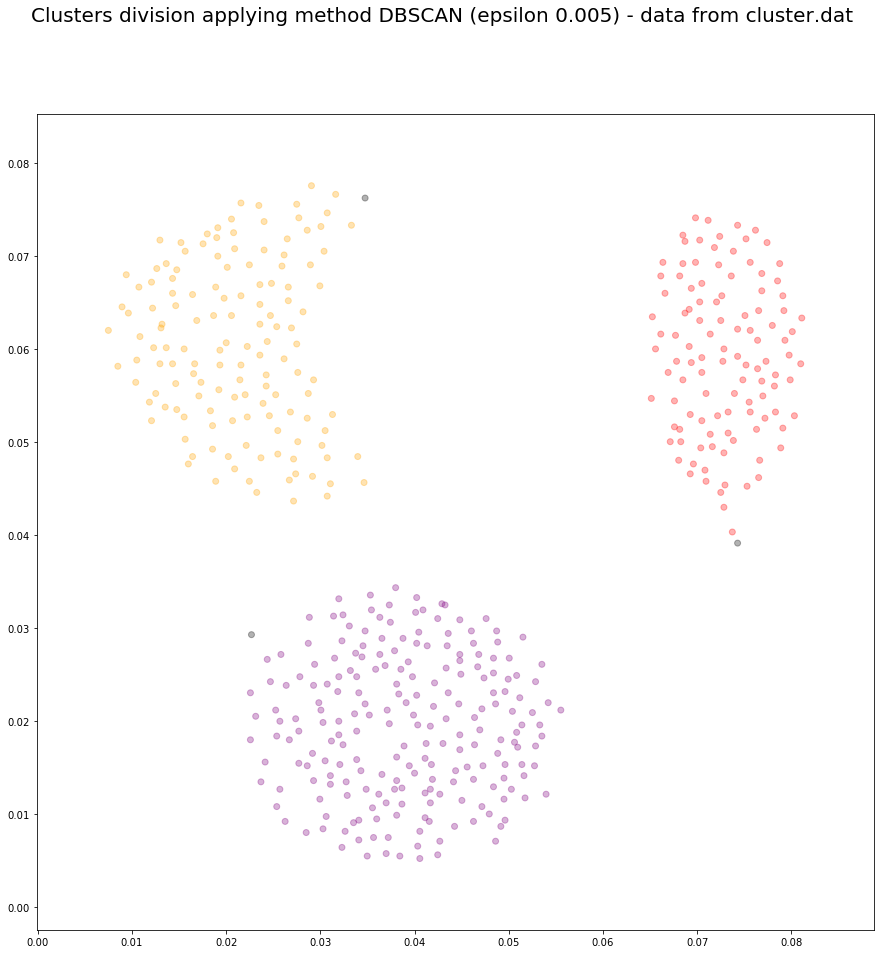

number of cluster found: 462
Counter({2: 214, 1: 137, 3: 109, 0: 3})
number of outliers found: 3



In [28]:
callPlot(norm_training,point_labels_train,
     'Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')
# callPlot(norm_training,point_labels_train,
#     'Training Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

In [35]:
clusters

NameError: name 'clusters' is not defined

In [4]:
A = [1,2,3,4]
B = [[1,2],[3,4]]
C = [i*(i == j) for i in A for k in B for j in k]
print(C)  

[1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4]


In [34]:
c_p = [0, 0, 0, 1, 1, 1, 2, 2]
n_p_d = [1, 3, 7]
e = 1

pt_labels = np.zeros(len(n_p_d),dtype=int)
 
for j in range(len(n_p_d)):
    for i in range(1,len(c_p)):
        if (module(n_p_d[j], c_p[i])  <= e):
            pt_labels[j] = n_p_d[j] 
            break              

print(pt_labels)

pt_labels = [ # boolean check - however, it will be gigant
            n_p_d[j]*
            (module(n_p_d[j], c_p[i])  <= e) 
            for i in range(1,len(c_p)) 
            for j in range(len(n_p_d))
            ]
print(pt_labels)

[1 3 0]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 3, 0, 1, 3, 0]


In [25]:
print(module(n_p_d[0], c_p[1]))

1.0


In [63]:
centroids_train

[[coluna 1   NaN
  coluna 2   NaN
  dtype: float64],
 [coluna 1    0.040316
  coluna 2    0.019450
  dtype: float64],
 [coluna 1    0.020551
  coluna 2    0.062740
  dtype: float64],
 [coluna 1    0.075381
  coluna 2    0.060455
  dtype: float64]]

In [ ]:
validate(train)

In [3]:
A = [[1,1],[1,1],[1,1]]
np.full(len(A), -1, dtype = int)

array([-1, -1, -1])